In [18]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np 
from geopandas import gpd
from shapely import wkt
from geopandas import GeoDataFrame

In [19]:
# uploaded finished intervention tables from 05_add_interventions.ipynb

intersection_intervention_table = pd.read_csv('../data/output/intersection_intervention_table_w_interventions_added.csv')

#### Adding Controls

##### Population

In [20]:
# from https://www.macrotrends.net/global-metrics/cities/23083/new-york-city/population
# source: United Nations - World Population Prospects

annual_pop = pd.read_csv('../data/input/nyc-metro-area_population_annual.csv').drop(columns=['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'])
annual_pop['Population'] = annual_pop['Population'].str.replace(',', '').astype(int)

In [21]:
# merging

intersection_intervention_table = intersection_intervention_table.merge(annual_pop[['Year','Population']], left_on = 'year', right_on = 'Year', how = 'left').drop(columns=['Year']).rename(columns={'Population':'nyc_metro_pop'})

##### Criminal Summonses - Traffic

In [22]:
# uncomment to pull from API and save
# can pull lat/ long too if desired, but makes the file way bigger
# nypd_summonses_historic = pd.read_csv('https://data.cityofnewyork.us/resource/sv2w-rv3k.csv?$select=summons_key,summons_date,offense_description,law_section_number,law_description,summons_category_type,boro,precinct_of_occur&$limit=9999999')
# traffic_summonses = nypd_summonses_historic[nypd_summonses_historic['law_description'].isin(['Traffic Regs', 'NYS Transportation', 'Traffic Rules'])]
# traffic_summonses.to_csv('../data/input/nyc_criminal-summonses_traffic_historic.csv', index=False)

# pull directly from downloaded file
traffic_summonses = pd.read_csv('../data/input/nyc_criminal-summonses_traffic_historic.csv')

# clean
traffic_summonses['summons_date'] = pd.to_datetime(traffic_summonses['summons_date'])
traffic_summonses = traffic_summonses.drop_duplicates()

In [23]:
# group by year
traffic_summonses_monthly = traffic_summonses[['summons_key']].groupby(traffic_summonses['summons_date'].dt.year).count().reset_index().rename(columns={'summons_date':'year', 'summons_key':'citywide_traffic_summonses'})

# merging with interventions dataset
intersection_intervention_table = intersection_intervention_table.merge(traffic_summonses_monthly[['year', 'citywide_traffic_summonses']], on='year', how = 'left')

<Axes: xlabel='year'>

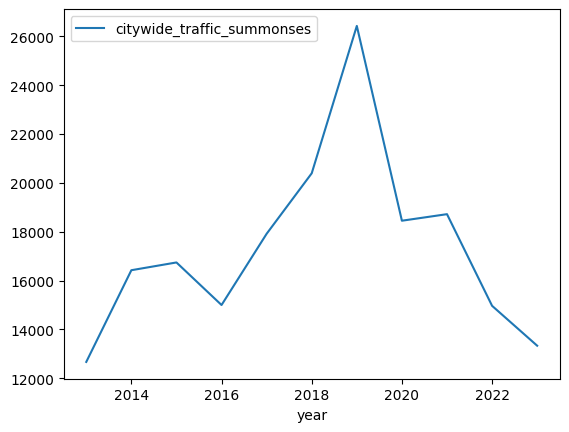

In [24]:
# looking at obsevration time period

traffic_summonses_monthly.set_index('year').loc['2013':'2023'].plot()

#### Daily Vehicle Miles Traveled (NYC Metro Area)

A measure of traffic volume

In [25]:
# manually compiled from https://www.fhwa.dot.gov/policyinformation/statistics/{INSERT YEAR}/hm71.cfm
dvmt = pd.read_csv('../data/input/daily-vehicle-miles-traveled_nyc-metro-area_2012-2023.csv')
dvmt = dvmt.replace(',', '', regex=True)
dvmt[dvmt.columns] = dvmt[dvmt.columns].astype(int)

# eliminate highways and interstates
dvmt['total minus highways'] = (
    dvmt['Total (DVMT in thousands)']
    - dvmt['Interstate (DVMT in thousands)']
    - dvmt['Other Freeways and Expressways (DVMT in thousands)']
)

# extrapolate the year 2024 (until it becomes available)
# may exclude 2024 anyway, but just in case

# prepare data modeling 
data = dvmt[['Year', 'total minus highways']].copy()
data['covid_2020'] = (data['Year'] == 2020).astype(int)
# fit linear regression model
X = data[['Year', 'covid_2020']]
y = data['total minus highways']
model = LinearRegression()
model.fit(X, y)
# predict for 2024 (covid_2020 = 0)
X_2024 = pd.DataFrame({'Year': [2024], 'covid_2020': [0]})
predicted_value = model.predict(X_2024)[0]

# add prediction to dataset
new_row = pd.DataFrame({'Year': [2024], 'total minus highways': [predicted_value]})
df_with_prediction = pd.concat(
    [dvmt[['Year', 'total minus highways']], new_row],
    ignore_index=True
).sort_values('Year')


In [26]:
# add to intervention df

# match types
intersection_intervention_table = intersection_intervention_table.merge(df_with_prediction, left_on = 'year', right_on = 'Year', how = 'left').drop(columns=['Year']).rename(columns={'total minus highways':'nyc_metro_dvmt'})

<Axes: xlabel='Year'>

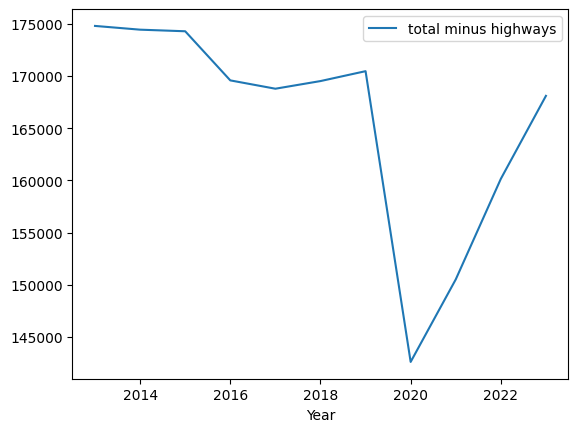

In [27]:
df_with_prediction.set_index('Year')[['total minus highways']].loc['2013':'2023'].plot()

#### NTA Population Density

In [28]:
# uploading NTA population numbers for 2009-2013, 2014-2018, and 2019-2023

# NTA matched to geometry
nta_geoms = gpd.read_file('../data/input/nta-population-estimates_2023-ACS5Year.geojson')[['ntaname','geometry']]

# 2013 numbers
nta_pop_2013 = gpd.read_file('../data/input/nta-population-estimates_2013-ACS5Year.geojson').rename(columns={'DP02_0086E':'population'})
nta_pop_2013['area_m2'] = nta_pop_2013.geometry.area
nta_pop_2013['area_sqmi'] = nta_pop_2013['area_m2'] * 0.0000003861
nta_pop_2013['pop_per_sqmi'] = (nta_pop_2013['population'] / nta_pop_2013['area_sqmi']).round(2)
nta_pop_2013['acs_year'] = 2013

# 2018 numbers
nta_pop_2018 = gpd.read_file('../data/input/nta-population-estimates_2018-ACS5Year.geojson').rename(columns={'DP02_0086E':'population'})
nta_pop_2018['area_m2'] = nta_pop_2018.geometry.area
nta_pop_2018['area_sqmi'] = nta_pop_2018['area_m2'] * 0.0000003861
nta_pop_2018['pop_per_sqmi'] = (nta_pop_2018['population'] / nta_pop_2018['area_sqmi']).round(2)
nta_pop_2018['acs_year'] = 2018

# 2023 numbers
nta_pop_2023 = gpd.read_file('../data/input/nta-population-estimates_2023-ACS5Year.geojson').rename(columns={'DP02_0088E':'population'})
nta_pop_2023['area_m2'] = nta_pop_2023.geometry.area
nta_pop_2023['area_sqmi'] = nta_pop_2023['area_m2'] * 0.0000003861
nta_pop_2023['pop_per_sqmi'] = (nta_pop_2023['population'] / nta_pop_2023['area_sqmi']).round(2)
nta_pop_2023['acs_year'] = 2023

# combine
nta_pop_numbers = pd.concat([nta_pop_2013, nta_pop_2018, nta_pop_2023])[['ntaname','acs_year', 'pop_per_sqmi', 'geometry']]

In [29]:
# get intersection locations

nyc_intersections_vz = pd.read_csv('../data/output/vz_nodes.csv')
nyc_intersections_vz['street_geom'] = nyc_intersections_vz['street_geom'].apply(wkt.loads)
nyc_intersections_vz['intersection_geom'] = nyc_intersections_vz['intersection_geom'].apply(wkt.loads)
nyc_intersections_vz = gpd.GeoDataFrame(nyc_intersections_vz, geometry='intersection_geom', crs='epsg:2263')
nyc_intersections_vz = nyc_intersections_vz.drop_duplicates(subset=['intersection_id'])
intersection_locations = nyc_intersections_vz[['intersection_id', 'intersection_geom']]
# creating key that matches intersections to NTA
intersections_matched_to_nta = intersection_locations.sjoin(nta_geoms).drop(columns=['index_right'])
# some intersections are placed in more than one NTA, so just keeping first one it's matched to
intersections_matched_to_nta = intersections_matched_to_nta.drop_duplicates(subset=['intersection_id'], keep='first')
# now match intersections to population density associated with each NTA/ year combo
intersections_matched_to_pop = intersections_matched_to_nta.merge(nta_pop_numbers, on='ntaname').drop(columns=['intersection_geom'])

In [30]:
# making it easier to map population density by year and intersection_id
# map each year to an ACS year
intersection_intervention_table['acs_year'] = intersection_intervention_table['year'].map({2012:2013,2013:2013,2014:2018,2015:2018,2016:2018,2017:2018,2018:2018,2019:2023,2020:2023,2021:2023,2022:2023,2023:2023,2024:2023,2025:2023})
intersection_intervention_table['year-intersection'] = intersection_intervention_table['acs_year'].astype(str) + intersection_intervention_table['intersection_id'].astype(str)
intersections_matched_to_pop['year-intersection'] = intersections_matched_to_pop['acs_year'].astype(str) + intersections_matched_to_pop['intersection_id'].astype(str)
# merging
intersection_intervention_table = intersection_intervention_table.merge(intersections_matched_to_pop[['year-intersection','pop_per_sqmi','ntaname']], on=['year-intersection'], how='left').drop(columns=['acs_year']).drop(columns=['year-intersection'])

#### Borough

In [31]:
# get intersection-borough matches

# creating key that matches intersections to borough
# borough matched to geometry
boro_geoms = gpd.read_file('../data/input/borough-boundaries.geojson')[['boro_name','geometry']].to_crs(2263)
intersections_matched_to_boro = intersection_locations.sjoin(boro_geoms).drop(columns=['index_right'])
# some intersections are placed in more than one borough, so just keeping first one it's matched to
intersections_matched_to_boro = intersections_matched_to_boro.drop_duplicates(subset=['intersection_id'], keep='first')
# adding borough column to df
intersection_intervention_table = intersection_intervention_table.merge(intersections_matched_to_boro[['intersection_id','boro_name']], on=['intersection_id'], how='left')

#### COVID

In [32]:
# covid

# version 1 (just 2020)
intersection_intervention_table['covid_2020'] = np.where(intersection_intervention_table['year'] == 2020, 1, 0)
# version 2 (pre vs post 2020)
intersection_intervention_table['covid_pre_post'] = np.where(intersection_intervention_table['year'] >= 2020, 1, 0)

##### Time Trend

In [33]:
# calculate the total number of years elapsed (time trend)
intersection_intervention_table['time'] = intersection_intervention_table['year'] - intersection_intervention_table['year'].min() + 1

##### Download

In [34]:
# when finished, download

intersection_intervention_table.to_csv('../data/output/intersection_intervention_table_final.csv', index=False)